# NOTEBOOK FOR DISPLAY OF PROCESS WE ALREADY WENT THROUGH TO ACHIEVE THIS MODEL AND SHOW UNDERSTANDING OF ML/COMMUNICATION SKILLS

# Weather Data Prediction 
### This notebook uses a Ridge regression model to predict high and low temperatures of data from May 2023 to July 2024.

## Import Libraries and Data

In [77]:
import pandas as pd
from sklearn.linear_model import Ridge
import joblib

# Read the CSV file into Pandas DataFrame
df = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Feature Engineering / Pandas for Data Preparation

In [78]:
# Remove columns of no interest
df = df[['location', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility',
       'moonphase', 'conditions', 'description']]

# Define columns to drop and features based on R-squared and VIF tests results
columns_to_drop = ['location', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'moonphase', 'conditions', 'description', 'predicted_tempmax', 'predicted_tempmin']
features = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Define targets
target_max = df['tempmax']
target_min = df['tempmin']

## Analysis / Presentation of Results

In [79]:
# Train the model for tempmax on the entire dataset
ridge_max = Ridge(alpha=0.1)
ridge_max.fit(features, target_max)

# Train the model for tempmin on the entire dataset
ridge_min = Ridge(alpha=100.0)
ridge_min.fit(features, target_min)

# Predict tempmax and tempmin for the entire dataset
y_pred_max = ridge_max.predict(features)
y_pred_min = ridge_min.predict(features)

# Create the prediction columns if they don't exist
if 'predicted_tempmax' not in df.columns:
    df['predicted_tempmax'] = pd.Series([0.0] * len(df), index=df.index)

if 'predicted_tempmin' not in df.columns:
    df['predicted_tempmin'] = pd.Series([0.0] * len(df), index=df.index)

# Add predictions to the original dataframe
df['predicted_tempmax'] = y_pred_max
df['predicted_tempmin'] = y_pred_min

# Ensure alignment by resetting the indices
df = df.sort_index()

# Display the dataframe with predictions
# Display only a few rows for quick verification
df[['location', 'tempmax', 'predicted_tempmax', 'tempmin', 'predicted_tempmin']].head(10)

,location,tempmax,predicted_tempmax,tempmin,predicted_tempmin
datetime,,,,,
2023-05-01,Beijing,25.2,24.793322,8.0,12.334292
2023-05-01,London,17.6,19.210062,11.3,10.509405
2023-05-01,Moscow,9.2,9.025468,3.4,3.586032
2023-05-01,Berlin,18.9,17.225393,3.4,6.747188
2023-05-01,Paris,15.7,16.694966,10.6,9.833487
2023-05-01,Mexico City,32.1,26.003736,5.0,9.184121
2023-05-01,Ottawa,9.9,11.563633,6.8,6.328336
2023-05-01,Rome,19.1,19.479011,14.1,12.152408
2023-05-01,Washington DC,16.0,20.207157,9.9,9.454410


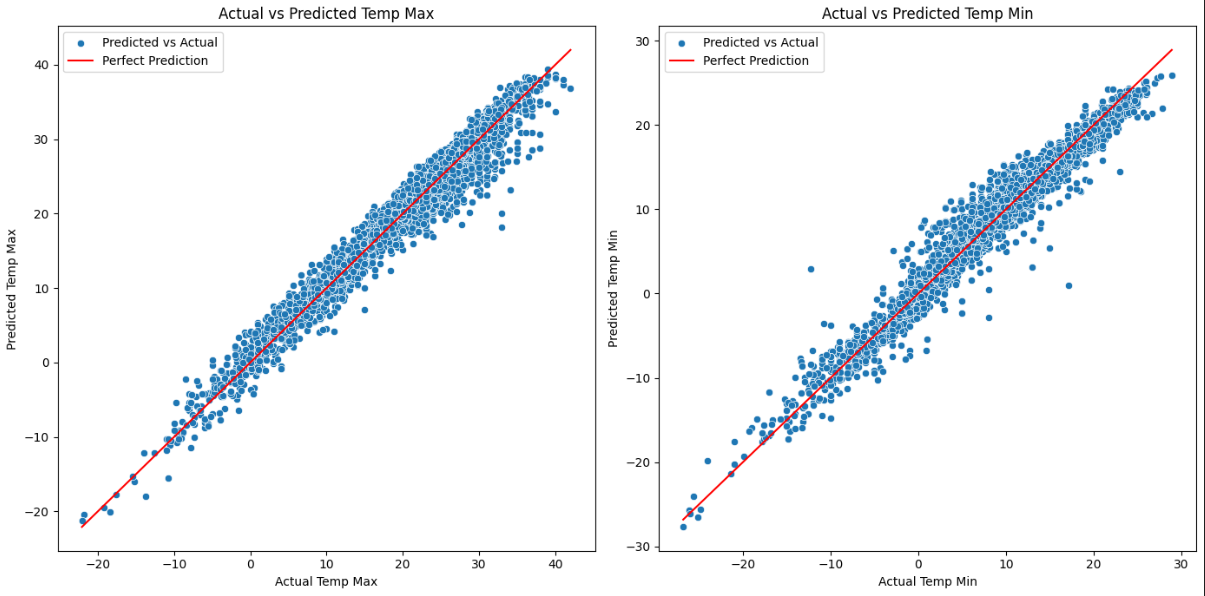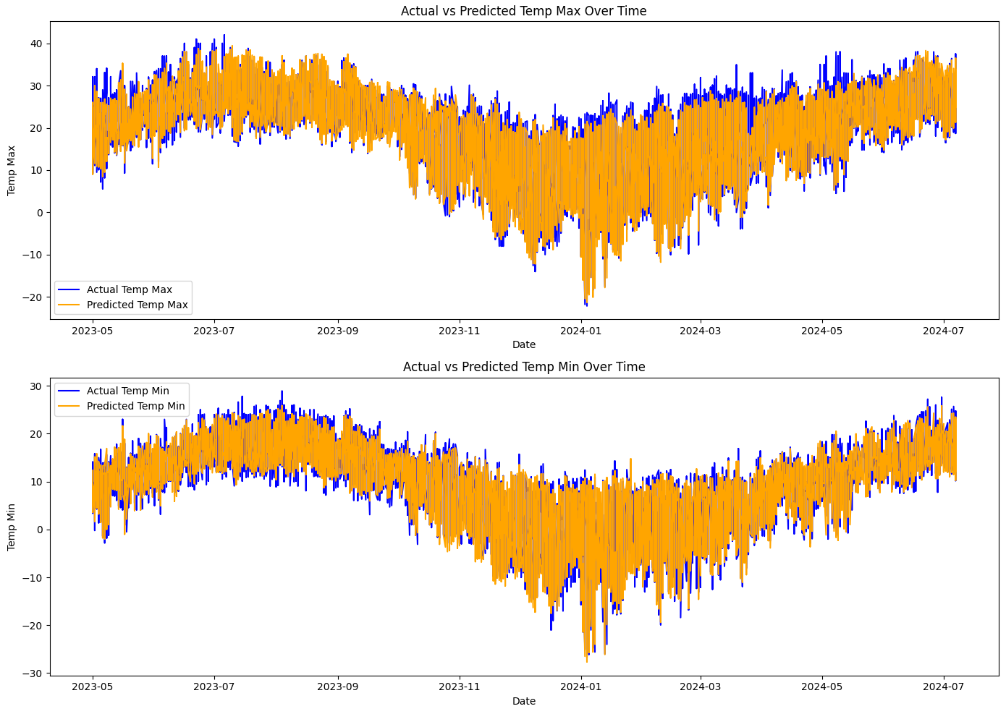

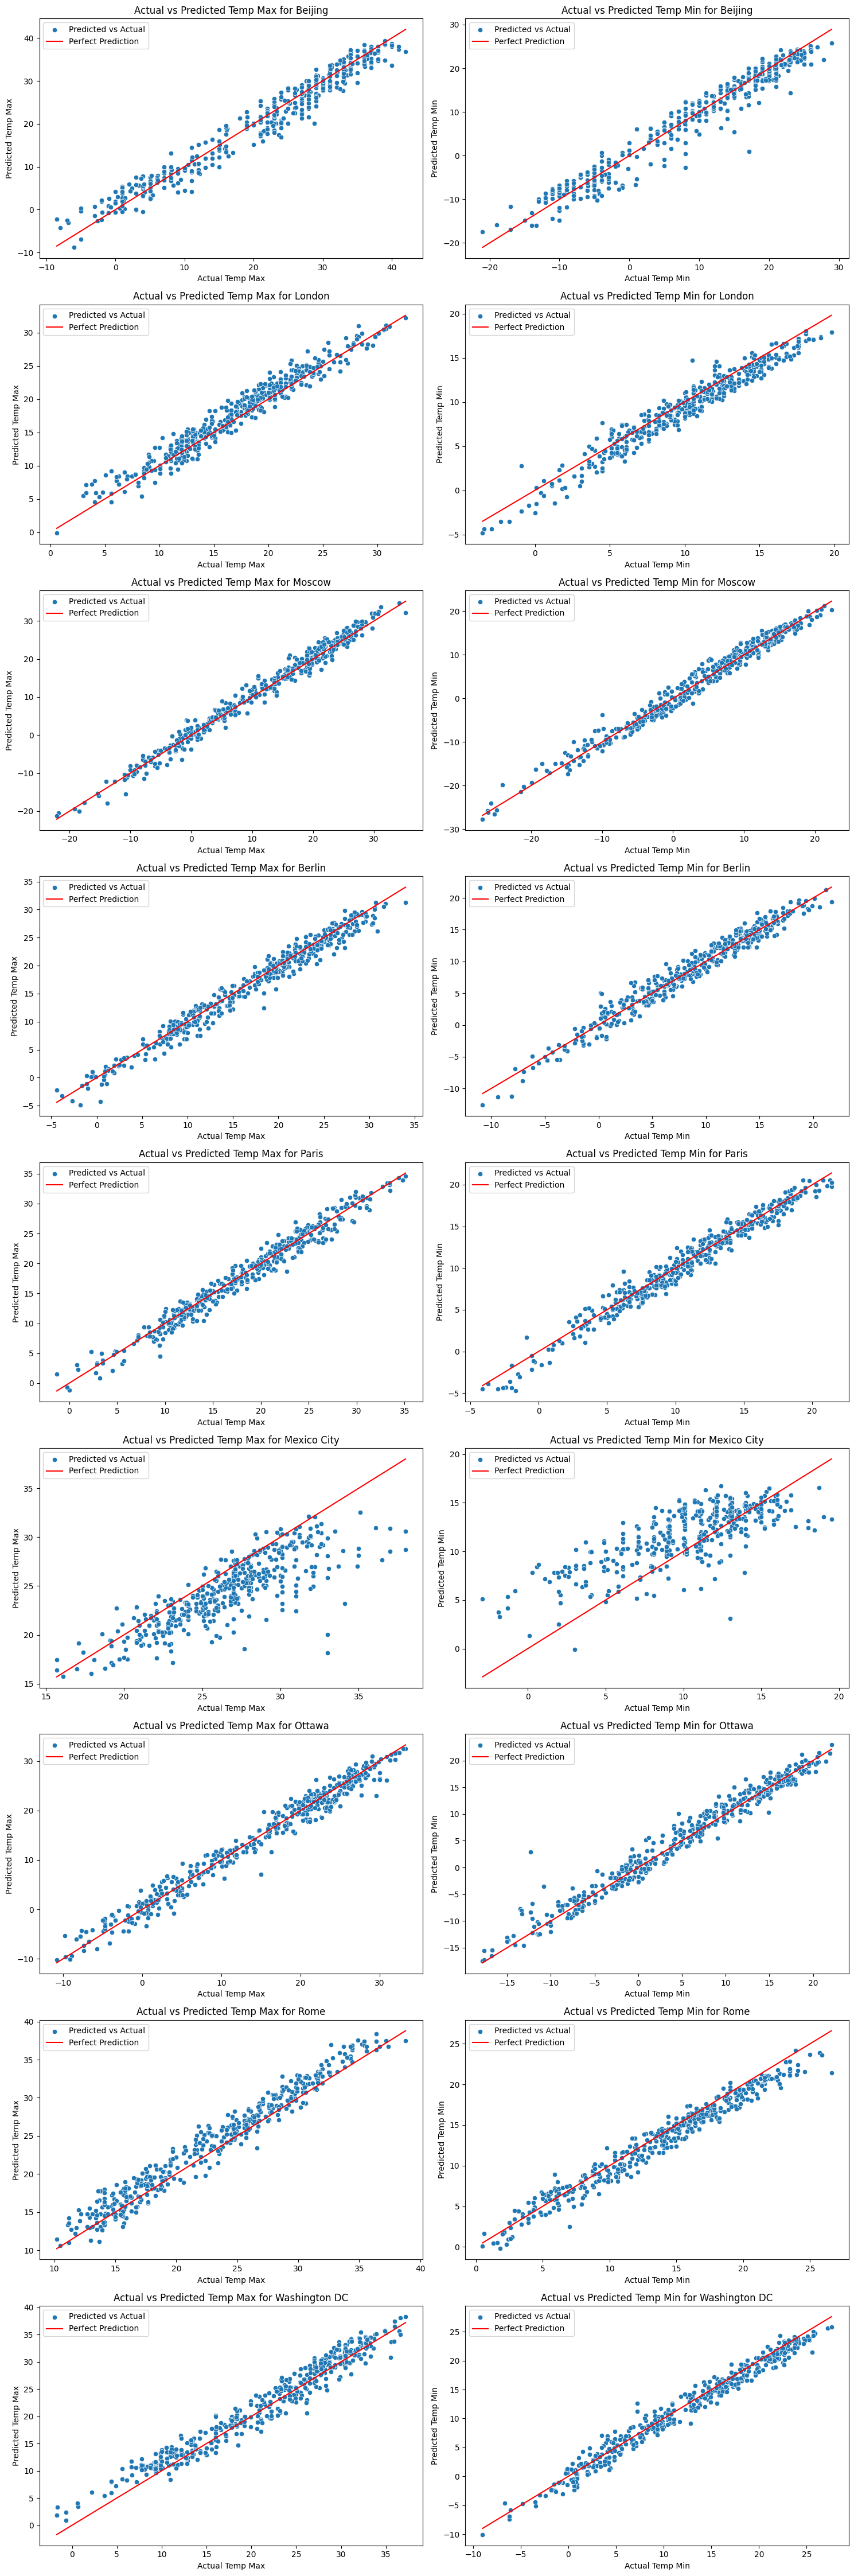

In [87]:


# Plotting by location
# Get the unique locations
locations = df['location'].unique()

# Calculate the grid size
num_locations = len(locations)
num_plots = num_locations * 2  # Each location needs 2 plots (tempmax and tempmin)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

# Create a large figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot data for each location
for i, location in enumerate(locations):
    # Filter the data for the current location
    df_location = df[df['location'] == location]

    # Plot for tempmax
    sns.scatterplot(x=df_location['tempmax'], y=df_location['predicted_tempmax'], ax=axes[i*2], label='Predicted vs Actual')
    sns.lineplot(x=df_location['tempmax'], y=df_location['tempmax'], ax=axes[i*2], color='red', label='Perfect Prediction')
    axes[i*2].set_title(f'Actual vs Predicted Temp Max for {location}')
    axes[i*2].set_xlabel('Actual Temp Max')
    axes[i*2].set_ylabel('Predicted Temp Max')
    axes[i*2].legend()

    # Plot for tempmin
    sns.scatterplot(x=df_location['tempmin'], y=df_location['predicted_tempmin'], ax=axes[i*2+1], label='Predicted vs Actual')
    sns.lineplot(x=df_location['tempmin'], y=df_location['tempmin'], ax=axes[i*2+1], color='red', label='Perfect Prediction')
    axes[i*2+1].set_title(f'Actual vs Predicted Temp Min for {location}')
    axes[i*2+1].set_xlabel('Actual Temp Min')
    axes[i*2+1].set_ylabel('Predicted Temp Min')
    axes[i*2+1].legend()

# Remove any unused subplots
for j in range(i*2+2, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()
plt.show()


## Store Results

In [81]:
# Save the models for future use
joblib.dump(ridge_max, 'ridge_model_tempmax.pkl')
joblib.dump(ridge_min, 'ridge_model_tempmin.pkl')

# Save the DataFrame with predictions to a new CSV file
df.to_csv("Weather_data_with_predictions.csv")

# Calculate metrics to check prediction accuracy

In [82]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE for tempmax and tempmin
mae_tempmax = mean_absolute_error(df['tempmax'], df['predicted_tempmax'])
mae_tempmin = mean_absolute_error(df['tempmin'], df['predicted_tempmin'])

# Calculate RMSE for tempmax and tempmin
rmse_tempmax = np.sqrt(mean_squared_error(df['tempmax'], df['predicted_tempmax']))
rmse_tempmin = np.sqrt(mean_squared_error(df['tempmin'], df['predicted_tempmin']))

# Calculate Reliability for tempmax and tempmin
reliability_tempmax = np.mean(np.abs(df['tempmax'] - df['predicted_tempmax']) <= 2) * 100
reliability_tempmin = np.mean(np.abs(df['tempmin'] - df['predicted_tempmin']) <= 2) * 100

# Calculate Inaccuracy for tempmax and tempmin
inaccuracy_tempmax = np.mean(np.abs(df['tempmax'] - df['predicted_tempmax']) > 5) * 100
inaccuracy_tempmin = np.mean(np.abs(df['tempmin'] - df['predicted_tempmin']) > 5) * 100

# Print the results
print(f"MAE for tempmax: {mae_tempmax:.2f}")
print(f"MAE for tempmin: {mae_tempmin:.2f}")

print(f"RMSE for tempmax: {rmse_tempmax:.2f}")
print(f"RMSE for tempmin: {rmse_tempmin:.2f}")

print(f"Reliability for tempmax: {reliability_tempmax:.2f}%")
print(f"Reliability for tempmin: {reliability_tempmin:.2f}%")

print(f"Inaccuracy for tempmax: {inaccuracy_tempmax:.2f}%")
print(f"Inaccuracy for tempmin: {inaccuracy_tempmin:.2f}%")


MAE for tempmax: 1.48
MAE for tempmin: 1.29
RMSE for tempmax: 1.94
RMSE for tempmin: 1.78
Reliability for tempmax: 72.68%
Reliability for tempmin: 81.95%
Inaccuracy for tempmax: 1.72%
Inaccuracy for tempmin: 2.12%


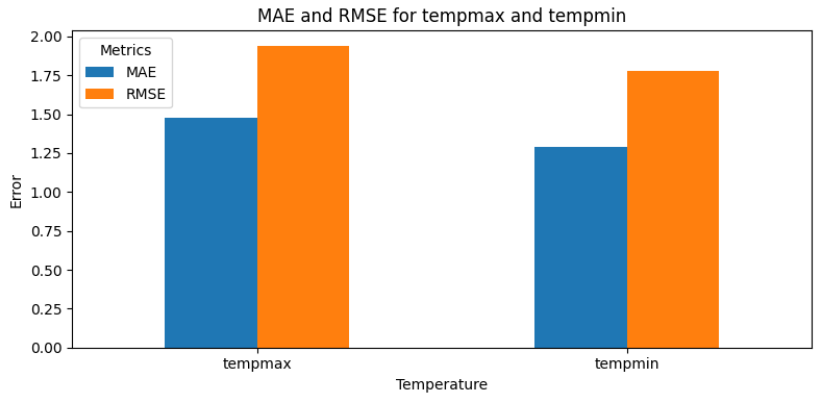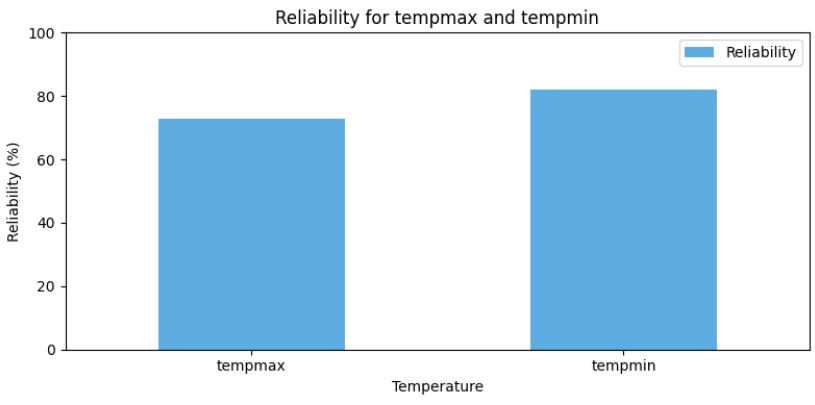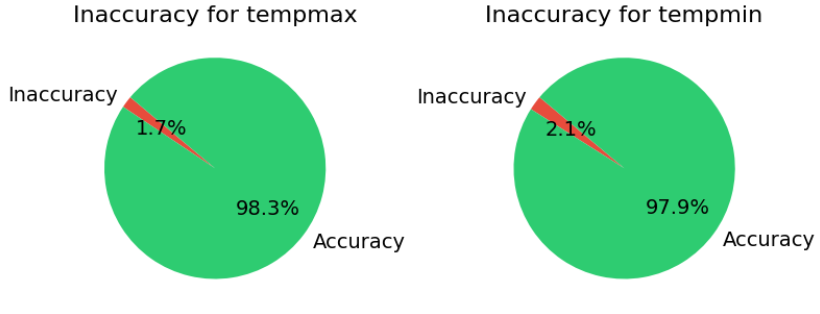

# Calculate PICP (prediction interval coverage probability) to determine model reliability

In [84]:
# Calculate residuals
residuals_max = df['tempmax'] - df['predicted_tempmax']
residuals_min = df['tempmin'] - df['predicted_tempmin']

# Calculate standard deviation of residuals
std_residuals_max = np.std(residuals_max)
std_residuals_min = np.std(residuals_min)

# Define the z-score for 95% prediction interval
z_score = 1.96

# Calculate prediction intervals
df['lower_bound_tempmax'] = df['predicted_tempmax'] - z_score * std_residuals_max
df['upper_bound_tempmax'] = df['predicted_tempmax'] + z_score * std_residuals_max

df['lower_bound_tempmin'] = df['predicted_tempmin'] - z_score * std_residuals_min
df['upper_bound_tempmin'] = df['predicted_tempmin'] + z_score * std_residuals_min

# Calculate coverage for tempmax
coverage_tempmax = np.logical_and(
    df['tempmax'] >= df['lower_bound_tempmax'],
    df['tempmax'] <= df['upper_bound_tempmax']
)

# Calculate coverage for tempmin
coverage_tempmin = np.logical_and(
    df['tempmin'] >= df['lower_bound_tempmin'],
    df['tempmin'] <= df['upper_bound_tempmin']
)

# Calculate PICP for tempmax
picp_tempmax = np.mean(coverage_tempmax) * 100

# Calculate PICP for tempmin
picp_tempmin = np.mean(coverage_tempmin) * 100

# Print the results
print(f"PICP for tempmax: {picp_tempmax:.2f}%")
print(f"PICP for tempmin: {picp_tempmin:.2f}%")

PICP for tempmax: 95.42%
PICP for tempmin: 94.83%
